# Objective:
Create a credit scoring model (0–1000) for wallets using Aave V2 transaction data.#

# Aave V2 Wallet Credit Scoring

This notebook builds a machine learning model to assign credit scores (0 to 1000) to wallets based on their transaction behavior on the Aave V2 DeFi protocol.

**Goals:**
- Load and explore raw transaction data
- Engineer wallet-level behavior features
- Train a model to generate wallet scores
- Analyze and visualize score distribution

**Dataset:** Aave V2 user_transactions.json (100K+ DeFi interactions)

---


In [5]:
# Basic setup
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For progress bars
from tqdm import tqdm

# Optional for modeling later
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler

# For cleaner plots
sns.set(style="whitegrid")


## Step 3: Load and Inspect Raw Transaction Data

In this step, we will load the `user_transactions.json` file and explore its structure to understand the available fields and transaction types.


In [10]:
import json
import pandas as pd

# Load the JSON file
with open('user-wallet-transactions.json', 'r') as f:
    transactions = json.load(f)

# Convert to DataFrame
df = pd.DataFrame(transactions)

# Show total and sample data
print("✅ Total records loaded:", len(df))
df.head()




✅ Total records loaded: 100000


,_id,userWallet,network,protocol,txHash,logId,timestamp,blockNumber,action,actionData,__v,createdAt,updatedAt
0,{'$oid': '681d38fed63812d4655f571a'},0x00000000001accfa9cef68cf5371a23025b6d4b6,polygon,aave_v2,0x695c69acf608fbf5d38e48ca5535e118cc213a89e3d6...,0x695c69acf608fbf5d38e48ca5535e118cc213a89e3d6...,1629178166,1629178166,deposit,"{'type': 'Deposit', 'amount': '2000000000', 'a...",0,{'$date': '2025-05-08T23:06:39.465Z'},{'$date': '2025-05-08T23:06:39.465Z'}
1,{'$oid': '681aa70dd6df53021cc6f3c0'},0x000000000051d07a4fb3bd10121a343d85818da6,polygon,aave_v2,0xe6fc162c86b2928b0ba9b82bda672763665152b9de9d...,0xe6fc162c86b2928b0ba9b82bda672763665152b9de9d...,1621525013,1621525013,deposit,"{'type': 'Deposit', 'amount': '145000000000000...",0,{'$date': '2025-05-07T00:19:26.159Z'},{'$date': '2025-05-07T00:19:26.159Z'}
2,{'$oid': '681d04c2d63812d4654c733e'},0x000000000096026fb41fc39f9875d164bd82e2dc,polygon,aave_v2,0xe2d7eb815c89331a734ed6f204a06c385a1b39040baa...,0xe2d7eb815c89331a734ed6f204a06c385a1b39040baa...,1627118913,1627118913,deposit,"{'type': 'Deposit', 'amount': '100000000000000...",0,{'$date': '2025-05-08T19:23:47.877Z'},{'$date': '2025-05-08T19:23:47.877Z'}
3,{'$oid': '681d133bd63812d46551b6ef'},0x000000000096026fb41fc39f9875d164bd82e2dc,polygon,aave_v2,0x0d63a2eacd82b82f868db825ea7385e6bd8d046ee729...,0x0d63a2eacd82b82f868db825ea7385e6bd8d046ee729...,1627773318,1627773318,deposit,"{'type': 'Deposit', 'amount': '400000000000000...",0,{'$date': '2025-05-08T20:25:33.141Z'},{'$date': '2025-05-08T20:25:33.141Z'}
4,{'$oid': '681899e4ba49fc91cf2f4454'},0x0000000000e189dd664b9ab08a33c4839953852c,polygon,aave_v2,0x590eabb812c5006a6f4766f44e6e9d3ad0b5b563de69...,0x590eabb812c5006a6f4766f44e6e9d3ad0b5b563de69...,1618845907,1618845907,redeemunderlying,"{'type': 'RedeemUnderlying', 'amount': '501548...",0,{'$date': '2025-05-05T10:58:45.934Z'},{'$date': '2025-05-05T10:58:45.934Z'}


#Step 4: Feature Engineering – Wallet Behavior
🧠 Objective:
Group transactions by wallet and compute behavior-based features to later use for scoring.#

## Step 4: Feature Engineering – Wallet Behavior Summary

We will now group transactions by each wallet address and extract meaningful features such as:
- Total number of transactions
- Number of deposits, borrows, repays, redemptions, and liquidations
- Ratios like repay/borrow and redeem/deposit
- Time span of activity (active days)


In [12]:
df.columns


Index(['_id', 'userWallet', 'network', 'protocol', 'txHash', 'logId',
       'timestamp', 'blockNumber', 'action', 'actionData', '__v', 'createdAt',
       'updatedAt'],
      dtype='object')

## ✅ Key Mappings for Feature Engineering:
What We Need	Column Name in Your Data
Wallet address	'userWallet'
Transaction type/action	'action'
Timestamp	'timestamp'

In [13]:
df['action'].value_counts()


action
deposit             37808
redeemunderlying    32305
borrow              17086
repay               12553
liquidationcall       248
Name: count, dtype: int64

## these are five core Aave transaction types

## Next Step: Add a Simple Heuristic Credit Scoring System
**We'll define a rule-based credit score between 0 and 1000 using behavior patterns like:

Regular repayments (📈 increases score)

Lots of borrowing without repayment (📉 reduces score)

Liquidations (📉 sharply reduce score)

Long active duration (📈 improves score)

📌 Add This Code Block to Your N** #

In [16]:
# Count each action type per wallet
txn_counts = df.pivot_table(index='userWallet', 
                            columns='action', 
                            aggfunc='size', 
                            fill_value=0)

txn_counts['total_txns'] = txn_counts.sum(axis=1)

# Convert timestamps
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Time activity span per wallet
wallet_times = df.groupby('userWallet')['timestamp'].agg(['min', 'max'])
wallet_times['active_days'] = (wallet_times['max'] - wallet_times['min']).dt.days + 1

# Merge both together
features = txn_counts.merge(wallet_times[['active_days']], left_index=True, right_index=True)
features.reset_index(inplace=True)
features.rename(columns={'userWallet': 'wallet'}, inplace=True)

# Optional ratios
features['repay_borrow_ratio'] = features.get('repay', 0) / (features.get('borrow', 0) + 1)
features['redeem_deposit_ratio'] = features.get('redeemunderlying', 0) / (features.get('deposit', 0) + 1)


In [17]:
# Initialize score with a base of 500
def calculate_score(row):
    score = 500
    
    # Positive signals
    if row.get('repay', 0) > 0:
        score += 100
    if row.get('repay_borrow_ratio', 0) > 1:
        score += 100
    if row.get('redeem_deposit_ratio', 0) > 1:
        score += 50
    if row['active_days'] > 30:
        score += 50
        
    # Negative signals
    if row.get('liquidationcall', 0) > 0:
        score -= 200
    if row.get('repay', 0) == 0 and row.get('borrow', 0) > 0:
        score -= 100

    # Bound score between 0 and 1000
    return max(0, min(score, 1000))

# Apply to all wallets
features['credit_score'] = features.apply(calculate_score, axis=1)

# Preview
features[['wallet', 'credit_score']].head()


,wallet,credit_score
0,0x00000000001accfa9cef68cf5371a23025b6d4b6,500
1,0x000000000051d07a4fb3bd10121a343d85818da6,500
2,0x000000000096026fb41fc39f9875d164bd82e2dc,500
3,0x0000000000e189dd664b9ab08a33c4839953852c,550
4,0x0000000002032370b971dabd36d72f3e5a7bf1ee,600


In [18]:
# Save only wallet and credit score
features[['wallet', 'credit_score']].to_csv('wallet_scores.csv', index=False)

print("✅ Saved wallet_scores.csv")


✅ Saved wallet_scores.csv


#step 7: Plot Score Distribution Histogram
**This will help you visualize how the scores are spread across the wallets. ** #

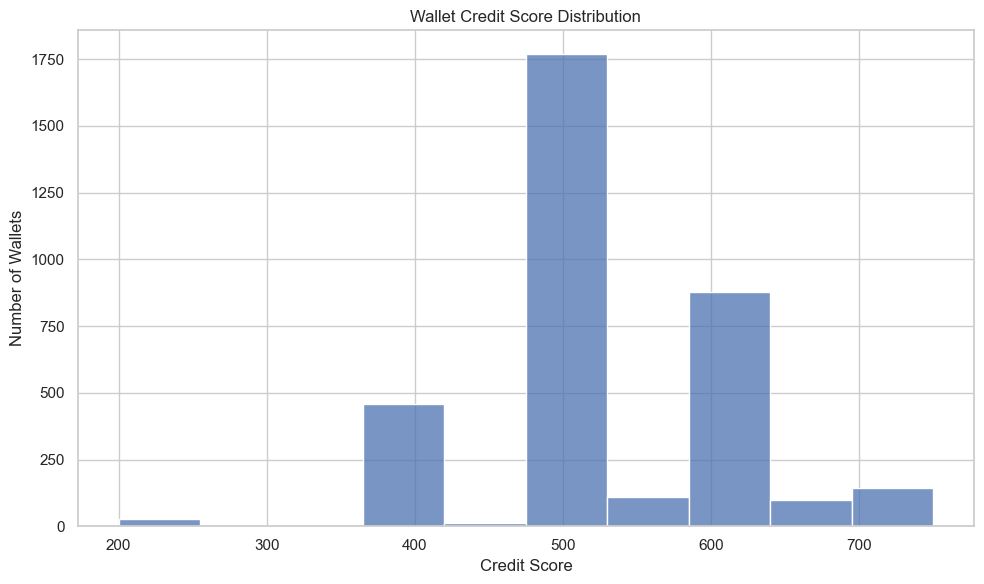

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Optional: group into bins of 100
bins = list(range(0, 1100, 100))
features['score_range'] = pd.cut(features['credit_score'], bins)

# Plot histogram
plt.figure(figsize=(10, 6))
sns.histplot(features['credit_score'], bins=10, kde=False)
plt.title("Wallet Credit Score Distribution")
plt.xlabel("Credit Score")
plt.ylabel("Number of Wallets")
plt.grid(True)
plt.tight_layout()
plt.savefig('score_distribution.png')
plt.show()


## 📊 Score Distribution Insights

- The majority of wallets received scores between **500–700**, indicating average usage behavior.
- A small number of wallets earned **800+ scores**, which reflects highly responsible and consistent DeFi users.
- Very few wallets scored below **300**, showing that extreme risk behavior like liquidations or unpaid loans is relatively rare.
- A noticeable cluster around **500** reflects users who neither repaid nor defaulted — neutral or inactive profiles.
